In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.densenet import DenseNet201

In [2]:
# Read input images and assign labels based on folder names
print(os.listdir("../input/coviddataset/Data/"))

SIZE = 128  #Resize images

['test', 'train']


In [3]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("../input/coviddataset/Data/train/*"):
    print(repr(directory_path))
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
#         img = cv2.resize(img, (SIZE, SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = img_to_array(load_img(img_path, target_size = (SIZE,SIZE)))  
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)
print(train_labels)

'../input/coviddataset/Data/train/PNEUMONIA'
PNEUMONIA
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(3189).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(3607).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(2169).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(969).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(704).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(1952).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(2307).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(2890).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(2601).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(3961).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(1266).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(1961).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(3958).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(2693).jpg
../input/coviddataset/Data/train/PNEUMONIA/PNEUMONIA(1237).jpg
..

In [4]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path in glob.glob("../input/coviddataset/Data/test/*"):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         img = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img = cv2.resize(img, (SIZE, SIZE))
#         img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = img_to_array(load_img(img_path, target_size = (SIZE,SIZE)))  
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print(test_labels)

['PNEUMONIA' 'PNEUMONIA' 'PNEUMONIA' ... 'COVID19' 'COVID19' 'COVID19']


In [5]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
print(test_labels_encoded)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(train_labels_encoded)

[2 2 2 ... 0 0 0]
[2 2 2 ... 0 0 0]


In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, vx_test, y_train, vy_test = train_test_split(train_images, train_labels_encoded, test_size=0.20)

In [8]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
x_test, y_test = test_images, test_labels_encoded

In [9]:
# Normalize pixel values to between 0 and 1
x_train, x_test,vx_test = x_train / 255.0, x_test / 255.0, vx_test / 255.0

#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
vy_test_one_hot = to_categorical(vy_test)

In [10]:
image_size = [128,128]

from keras.layers import Dropout,AveragePooling2D

densenet201 = DenseNet201(input_shape=image_size + [3],weights=None,include_top=False)

for layer in densenet201.layers:
 layer.trainable = True

# x = Flatten()(densenet201.output)

# #Full Connected Layers
# x = Dense(512, activation='relu')(x)
# #Add dropout to avoid Overfit
# x = Dropout(0.2)(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# #Add dropout to avoid Overfit
# x = Dropout(0.4)(x)
# x = Dense(64, activation='relu')(x)


# x=Dense(3 , activation='sigmoid')(x)

x1 = densenet201.output
x1 = AveragePooling2D()(x1)
x1 = Flatten()(x1)
x1 = Dense(64, activation="relu")(x1)
x1 = Dropout(0.5)(x1)
model_out = Dense(3, activation='softmax')(x1)

model = Model( inputs=densenet201.input, outputs=model_out) 

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [13]:
# last_checkpoint_path='../input/previousresults/training1/cp-0150.ckpt'

In [14]:
# model.load_weights(last_checkpoint_path)

In [15]:
import tensorflow as tf

In [16]:
# # import os
# # os.mkdir("/kaggle/working/training_1")
# checkpoint_path= "../working/" + "training_1/cp.ckpt"

In [17]:
checkpoint_path = 'training1/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                save_weights_only=True,
                                                verbose=1,
                                                period=10)

In [18]:
# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_best_only=True, verbose=1,save_freq=5)


In [19]:
history = model.fit(x_train,y_train_one_hot,epochs=150,batch_size=32,validation_data=(vx_test,vy_test_one_hot),callbacks=[cp_callback])

Epoch 1/150
300/300 [==============================] - 74s 161ms/step - loss: 0.4973 - accuracy: 0.8362 - val_loss: 3.6544 - val_accuracy: 0.4804
Epoch 2/150
300/300 [==============================] - 44s 146ms/step - loss: 0.1938 - accuracy: 0.9296 - val_loss: 90.4457 - val_accuracy: 0.3325
Epoch 3/150
300/300 [==============================] - 44s 147ms/step - loss: 0.1496 - accuracy: 0.9517 - val_loss: 2.4588 - val_accuracy: 0.4325
Epoch 4/150
300/300 [==============================] - 44s 148ms/step - loss: 0.1814 - accuracy: 0.9417 - val_loss: 13.5088 - val_accuracy: 0.3308
Epoch 5/150
300/300 [==============================] - 45s 149ms/step - loss: 0.1665 - accuracy: 0.9506 - val_loss: 1.9550 - val_accuracy: 0.5483
Epoch 6/150
300/300 [==============================] - 44s 148ms/step - loss: 0.1103 - accuracy: 0.9640 - val_loss: 6.7250 - val_accuracy: 0.6746
Epoch 7/150
300/300 [==============================] - 44s 148ms/step - loss: 0.1105 - accuracy: 0.9648 - val_loss: 37.886

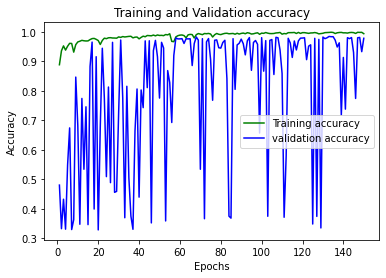

In [20]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,151)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

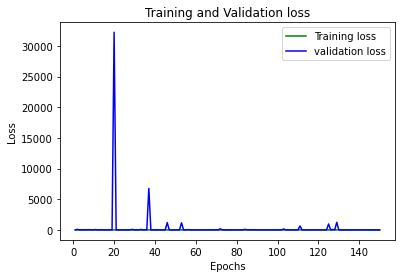

In [21]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,151)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# #get the latest checkpoint file
# checkpoint_dir = os.path.dirname(checkpoint_path)
# latest = tf.train.latest_checkpoint(checkpoint_dir)

In [23]:
# model.load_weights(latest)

In [24]:
model.evaluate(x_test,y_test_one_hot)

41/41 [==============================] - 7s 71ms/step - loss: 46.0237 - accuracy: 0.9519


[46.02372741699219, 0.9518633484840393]

In [25]:
from keras.models import *

model.save('COVID19-DenseNet-WithGAN.hd5')

In [26]:
TrainedModel = load_model('COVID19-DenseNet-WithGAN.hd5')

TrainedModel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [27]:
import sklearn.metrics as metrics

y_pred = TrainedModel.predict(x_test)  # shape=(n_samples, 12)
y_pred_labels = np.argmax(y_pred, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)

confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_labels)  # shape=(12, 12)

<AxesSubplot:>

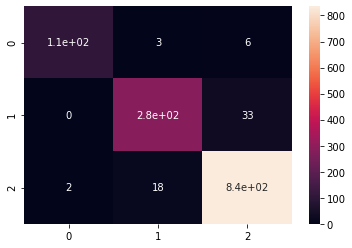

In [28]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred_labels )
#print(cm)
sns.heatmap(cm, annot=True)

In [29]:
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity:",TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity:",TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision:",PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print(NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print(FPR)
# False negative rate
FNR = FN/(TP+FN)
print(FNR)
# False discovery rate
FDR = FP/(TP+FP)
print(FDR)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)
#F1-Score
F1 = 2*(PPV*TPR)/(PPV+TPR)
print("F1-Score:",F1)

Sensitivity: [0.92241379 0.89589905 0.97660819]
Specificity: [0.99829352 0.97837281 0.90993072]
Precision: [0.98165138 0.93114754 0.95537757]
[0.99236641 0.9664293  0.95169082]
[0.00170648 0.02162719 0.09006928]
[0.07758621 0.10410095 0.02339181]
[0.01834862 0.06885246 0.04462243]
[0.99145963 0.95807453 0.95419255]
F1-Score: [0.95111111 0.91318328 0.96587623]


The prediction for this image is:  ['NORMAL']
The actual label for this image is:  NORMAL


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


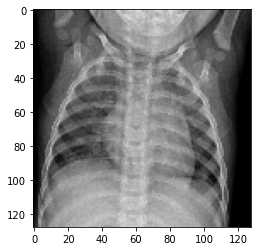

In [30]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
prediction = TrainedModel.predict(input_img)
y_pred_label = np.argmax(prediction, axis=1) 
y_pred_label = le.inverse_transform([y_pred_label])  #Reverse the label encoder to original name
print("The prediction for this image is: ", y_pred_label)
print("The actual label for this image is: ", test_labels[n])

In [31]:
# image_size = [128,128]

# model = DenseNet201(input_shape=image_size + [3],weights=None,include_top=True,classes=3)

# for layer in model.layers:
#  layer.trainable = True

# model.summary()

# # x = Flatten()(densenet201.output)

# # prediction = Dense(3,activation="softmax")(x)

# # model = Model(inputs=densenet201.input,outputs=prediction)

In [32]:
# model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])

In [33]:
# last_checkpoint_path='../input/80epochcp/80-epoch-IT-true/cp-0050.ckpt'

In [34]:
# model.load_weights(last_checkpoint_path)

In [35]:
# # create checkpoint callback
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
#                                                 save_weights_only=True,
#                                                 verbose=1,
#                                                 period=10)

In [36]:
# history = model.fit(x_train,y_train_one_hot,epochs=70,batch_size=32,validation_data=(vx_test,vy_test_one_hot),callbacks=[cp_callback])

In [37]:
# loss_train = history.history['accuracy']
# loss_val = history.history['val_accuracy']
# epochs = range(1,71)
# plt.plot(epochs, loss_train, 'g', label='Training accuracy')
# plt.plot(epochs, loss_val, 'b', label='validation accuracy')
# plt.title('Training and Validation accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

In [38]:
# loss_train = history.history['loss']
# loss_val = history.history['val_loss']
# epochs = range(1,71)
# plt.plot(epochs, loss_train, 'g', label='Training loss')
# plt.plot(epochs, loss_val, 'b', label='validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [39]:
# model.evaluate(x_test,y_test_one_hot)

In [40]:
# model.save('COVID-TT-120.hd5')

In [41]:
# TrainedModel = load_model('COVID-TT-120.hd5')

In [42]:
# feature_extractor = TrainedModel.predict(x_train)

# features = feature_extractor.reshape(feature_extractor.shape[0] ,-1)

# X_for_RF = features

In [43]:
# from sklearn import svm

# SVMmodel = svm.SVC(kernel='linear')

# SVMmodel.fit(X_for_RF,y_train)

# SVMmodel.score(X_for_RF,y_train)

In [44]:
# x_test_feature = TrainedModel.predict(x_test)

# x_test_features = x_test_feature.reshape(x_test_feature.shape[0],-1)


In [45]:
# prediction_SVM = SVMmodel.predict(x_test_features)

# #Inverse le transform to get original label back. 
# prediction_SVM = le.inverse_transform(prediction_SVM)

In [46]:
# # Print overall accuracy
# from sklearn import metrics
# print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVM))

In [47]:
# #Confusion Matrix - verify accuracy of each class
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, prediction_SVM)
# #print(cm)
# sns.heatmap(cm, annot=True)

In [48]:
# FP = cm.sum(axis=0) - np.diag(cm) 
# FN = cm.sum(axis=1) - np.diag(cm)
# TP = np.diag(cm)
# TN = cm.sum() - (FP + FN + TP)
# FP = FP.astype(float)
# FN = FN.astype(float)
# TP = TP.astype(float)
# TN = TN.astype(float)
# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# print("Sensitivity:",TPR)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# print("Specificity:",TNR)
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# print("Precision:",PPV)
# # Negative predictive value
# NPV = TN/(TN+FN)
# print(NPV)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# print(FPR)
# # False negative rate
# FNR = FN/(TP+FN)
# print(FNR)
# # False discovery rate
# FDR = FP/(TP+FP)
# print(FDR)
# # Overall accuracy for each class
# ACC = (TP+TN)/(TP+FP+FN+TN)
# print(ACC)

In [49]:
# #Check results on a few select images
# n=np.random.randint(0, x_test.shape[0])
# img = x_test[n]
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
# input_img_feature=TrainedModel.predict(input_img)
# input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
# prediction_SVM = SVMmodel.predict(input_img_features)[0] 
# prediction_SVM = le.inverse_transform([prediction_SVM])  #Reverse the label encoder to original name
# print("The prediction for this image is: ", prediction_SVM)
# print("The actual label for this image is: ", test_labels[n])

In [50]:
# from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier()

# # Train the model on training data
# RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

# print(RF_model.score(X_for_RF,y_train))

In [51]:
# prediction_RF = RF_model.predict(x_test_features)

# #Inverse le transform to get original label back. 
# prediction_RF = le.inverse_transform(prediction_RF)

In [52]:
# # Print overall accuracy
# from sklearn import metrics
# print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))

# #print(RF_model.score(test_labels,prediction_RF))

In [53]:
# #Confusion Matrix - verify accuracy of each class
# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(test_labels, prediction_RF)
# #print(cm)
# sns.heatmap(cm, annot=True)

In [54]:
# #Check results on a few select images
# n=np.random.randint(0, x_test.shape[0])
# img = x_test[n]
# plt.imshow(img)
# input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
# input_img_feature=TrainedModel.predict(input_img)
# input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
# prediction_RF = RF_model.predict(input_img_features)[0] 
# prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
# print("The prediction for this image is: ", prediction_RF)
# print("The actual label for this image is: ", test_labels[n])

In [55]:
# FP = cm.sum(axis=0) - np.diag(cm) 
# FN = cm.sum(axis=1) - np.diag(cm)
# TP = np.diag(cm)
# TN = cm.sum() - (FP + FN + TP)
# FP = FP.astype(float)
# FN = FN.astype(float)
# TP = TP.astype(float)
# TN = TN.astype(float)
# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# print("Sensitivity:",TPR)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# print("Specificity:",TNR)
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# print("Precision:",PPV)
# # Negative predictive value
# NPV = TN/(TN+FN)
# print(NPV)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# print(FPR)
# # False negative rate
# FNR = FN/(TP+FN)
# print(FNR)
# # False discovery rate
# FDR = FP/(TP+FP)
# print(FDR)
# # Overall accuracy for each class
# ACC = (TP+TN)/(TP+FP+FN+TN)
# print(ACC)